In [1]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time
import os
import matplotlib.image as img
import sklearn.metrics
from PIL import Image

from keras.losses import BinaryCrossentropy
from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential


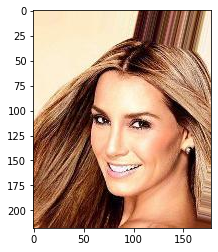

(218, 178, 3)


In [2]:
allImgPath = []
#fullImgPath = "C:/Users/Belg/Downloads/archive(1)/celeba_hq/val/female"
fullImgPath = "C:/Users/Belg/OneDrive - OST\Master's/02_Semester/VA/celeba/img_align_celeba"

for path in os.listdir(fullImgPath):
    if ".jpg" in path:
        allImgPath.append(os.path.join(fullImgPath,path))

image = img.imread(allImgPath[0])
plt.imshow(image)
plt.show()
print(image.shape)

In [3]:
partImgPath = allImgPath[40001:60000]
cropping = (0,20,178,208)

xTrain = [np.array((Image.open(path).convert('L').crop(cropping)).resize((16,16))) for path in partImgPath]

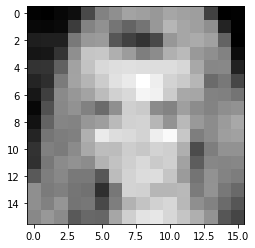

(16, 16)


In [4]:
plt.imshow(xTrain[0],cmap="gray")
plt.show()
print(xTrain[0].shape)

In [5]:
for i in range(len(xTrain)):
    xTrain[i] = xTrain[i]/127.5-1 #tanh -->[-1,1]

xTrain = np.array(xTrain)

In [6]:
#xTrain=xTrain[0:50000]
xTrain.shape

(19999, 16, 16)

<Figure size 720x720 with 0 Axes>

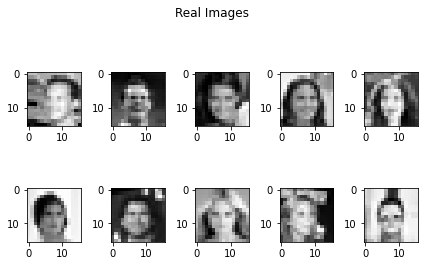

In [7]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(((xTrain[idx])* 0.5 + 0.5).reshape(16,16,1),cmap="gray")            
            idx+=6
            
plt.tight_layout()
plt.show()

In [8]:
batchSize = 16
nepochs = 1000
zDim = 256
imgShape = (16,16,1)
sampleInterval = 1

In [9]:
with tf.device('/CPU:0'):
    trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

<font style="color:red"><h1>Model Architecture </h1></font>

In [10]:
oldgenerator = K.models.load_model("8_Celeb_a_CNNgenerator")
oldgenerator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              1052672   
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 4, 4, 512)        4719104   
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 4, 4, 512)       

In [11]:
def buildGenerator():

    model = Sequential()
    model.add(Dense(1024 * 2 * 2, input_shape=(zDim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape([2, 2, 1024]))

    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, kernel_size=3, padding='same', activation="tanh"))

    return model

buildGenerator().summary()
generator = buildGenerator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        4719104   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 512)        2

In [12]:
for i in range((len(oldgenerator.layers)-2)):
    generator.layers[i].set_weights(oldgenerator.layers[i].get_weights())

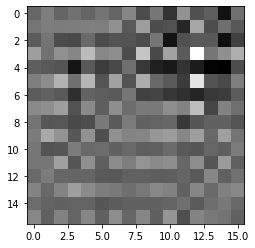

In [13]:
#generate noise image
noise = tf.random.normal([1, zDim])
generatedImage = generator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5,cmap="gray")
plt.show()


In [14]:
olddiscriminator = K.models.load_model("8_Celeb_a_CNNdiscriminator")
olddiscriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 4, 4, 64)          640       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 4, 4, 64)          0         
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 64)          0         
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 2, 128)         73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 2, 2, 128)         0         
                                                                 
 dropout_11 (Dropout)        (None, 2, 2, 128)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 1, 256)        

In [15]:
def buildDiscriminator():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=imgShape,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(512,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(1024,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

buildDiscriminator().summary()
discriminator = buildDiscriminator()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 32)          320       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)        

In [16]:
discriminator = buildDiscriminator()
for i in range(4,len(olddiscriminator.layers)):
    discriminator.layers[i].set_weights(olddiscriminator.layers[i-3].get_weights())

In [17]:
#classyfy with discriminator
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[0.3199804]], shape=(1, 1), dtype=float32)


In [18]:
#classyfy with discriminator
x = tf.convert_to_tensor(xTrain[0].reshape(1,16,16,1))
decision = discriminator(x, training = False)
print (decision)

tf.Tensor([[0.3090289]], shape=(1, 1), dtype=float32)


<font style="color:red"><h1>Train GAN </h1></font>

In [19]:
def sampleImg(generator,imgGridRow = 4, imgGridColumn = 4):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

<font style="color:red"><h2>Gradient Tape </h2></font>

In [20]:
crossentropy = BinaryCrossentropy(from_logits=False)

def discriminatorLoss(real, fake):
    realLoss = crossentropy(tf.ones_like(real), real)
    fakeLoss = crossentropy(tf.zeros_like(fake), fake)
    return realLoss + fakeLoss

def generatorLoss(fake):
    return crossentropy(tf.ones_like(fake), fake)
    
generatorOptimiser = tf.keras.optimizers.Adam()
discriminatorOptimiser = tf.keras.optimizers.Adam()

In [21]:
@tf.function
def train_step_GT(images):
    noise = tf.random.normal([batchSize, zDim])

    with tf.GradientTape() as gTape, tf.GradientTape() as dTape:
      genImg = generator(noise, training=True)

      real = discriminator(images, training=True)
      fake = discriminator(genImg, training=True)

      gLoss = generatorLoss(fake)
      dLoss = discriminatorLoss(real, fake)

    gradientsOfGenerator = gTape.gradient(gLoss, generator.trainable_variables)
    gradientsOfDiscriminator = dTape.gradient(dLoss, discriminator.trainable_variables)

    generatorOptimiser.apply_gradients(zip(gradientsOfGenerator, generator.trainable_variables))
    discriminatorOptimiser.apply_gradients(zip(gradientsOfDiscriminator, discriminator.trainable_variables))

    return gLoss,dLoss

In [25]:
def accuracy(batch):
    noise = tf.random.normal([batchSize, zDim])
    genimg = generator(noise, training=False)
    pred = np.round(tf.get_static_value(discriminator(genimg, training=False)),0)
    fake = tf.zeros_like(pred)
    accF = sklearn.metrics.accuracy_score(fake,pred)*100

    noise = tf.random.normal([batchSize, zDim])
    genimg = generator(noise, training=False)
    pred = np.round(tf.get_static_value(discriminator(batch, training=False)),0)
    real = tf.ones_like(pred)
    accR = sklearn.metrics.accuracy_score(real,pred)*100

    return (accF+accR)/2, np.mean(discriminator(genimg, training = False))

In [26]:
def training_GT():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step_GT(batch)
      genLoss,disLoss = train_step_GT(batch)

      acc, decision = accuracy(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

      if acc <=50 and decision>=0.5:
        break

Time for epoch 1 is 37.0 sec
Epoch:  1 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  240.91
---------------------------------------------------------------------------------------------------------------------------------------------------------------


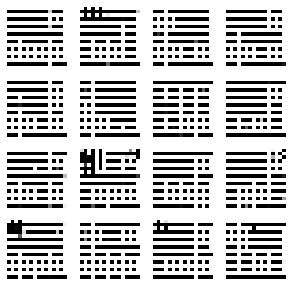

Time for epoch 2 is 36.0 sec
Epoch:  2 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  42.39
---------------------------------------------------------------------------------------------------------------------------------------------------------------


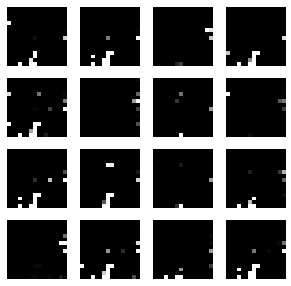

Time for epoch 3 is 36.0 sec
Epoch:  3 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  22.71
---------------------------------------------------------------------------------------------------------------------------------------------------------------


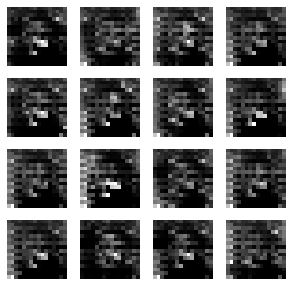

Time for epoch 4 is 36.0 sec
Epoch:  4 | Discriminator Loss:  0.01 | Accuracy:  100.0 % | Generator Loss:  18.2
---------------------------------------------------------------------------------------------------------------------------------------------------------------


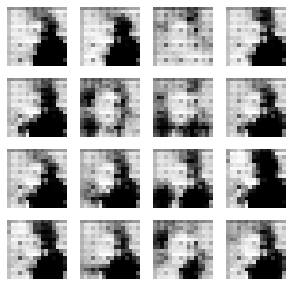

Time for epoch 5 is 36.0 sec
Epoch:  5 | Discriminator Loss:  0.28 | Accuracy:  96.67 % | Generator Loss:  11.19
---------------------------------------------------------------------------------------------------------------------------------------------------------------


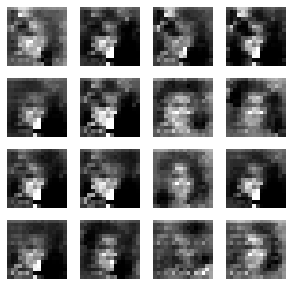

Time for epoch 6 is 36.0 sec
Epoch:  6 | Discriminator Loss:  0.29 | Accuracy:  96.88 % | Generator Loss:  9.48
---------------------------------------------------------------------------------------------------------------------------------------------------------------


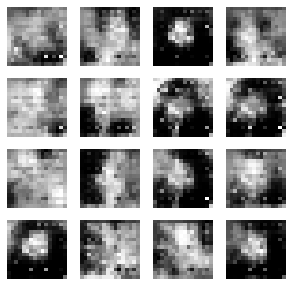

Time for epoch 7 is 36.0 sec
Epoch:  7 | Discriminator Loss:  0.47 | Accuracy:  96.67 % | Generator Loss:  4.75
---------------------------------------------------------------------------------------------------------------------------------------------------------------


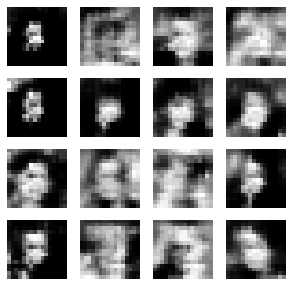

Time for epoch 8 is 36.0 sec
Epoch:  8 | Discriminator Loss:  0.59 | Accuracy:  86.88 % | Generator Loss:  3.12
---------------------------------------------------------------------------------------------------------------------------------------------------------------


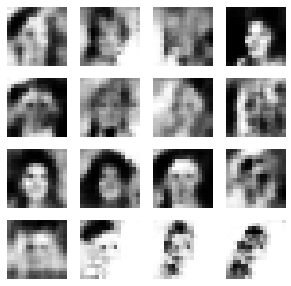

Time for epoch 9 is 36.0 sec
Epoch:  9 | Discriminator Loss:  0.64 | Accuracy:  86.67 % | Generator Loss:  2.09
---------------------------------------------------------------------------------------------------------------------------------------------------------------


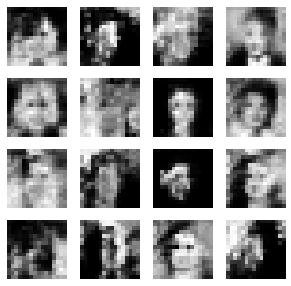

Time for epoch 10 is 36.0 sec
Epoch:  10 | Discriminator Loss:  0.89 | Accuracy:  86.88 % | Generator Loss:  2.2
---------------------------------------------------------------------------------------------------------------------------------------------------------------


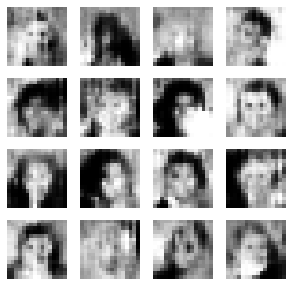

Time for epoch 11 is 36.0 sec
Epoch:  11 | Discriminator Loss:  0.97 | Accuracy:  83.33 % | Generator Loss:  1.86
---------------------------------------------------------------------------------------------------------------------------------------------------------------


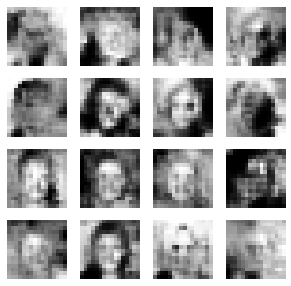

Time for epoch 12 is 36.0 sec
Epoch:  12 | Discriminator Loss:  0.91 | Accuracy:  90.0 % | Generator Loss:  2.02
---------------------------------------------------------------------------------------------------------------------------------------------------------------


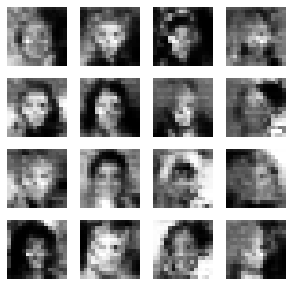

Time for epoch 13 is 36.0 sec
Epoch:  13 | Discriminator Loss:  0.88 | Accuracy:  86.67 % | Generator Loss:  1.47
---------------------------------------------------------------------------------------------------------------------------------------------------------------


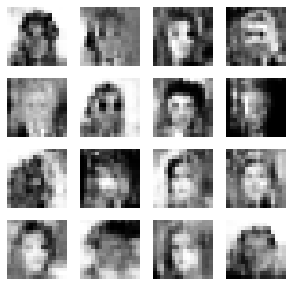

Time for epoch 14 is 36.0 sec
Epoch:  14 | Discriminator Loss:  1.35 | Accuracy:  70.42 % | Generator Loss:  1.02
---------------------------------------------------------------------------------------------------------------------------------------------------------------


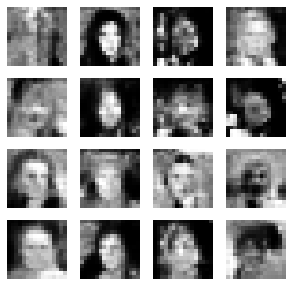

Time for epoch 15 is 36.0 sec
Epoch:  15 | Discriminator Loss:  1.22 | Accuracy:  83.96 % | Generator Loss:  0.68
---------------------------------------------------------------------------------------------------------------------------------------------------------------


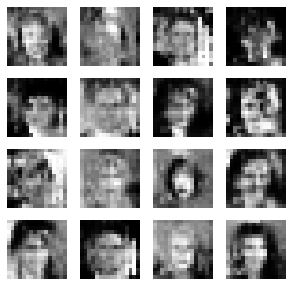

Time for epoch 16 is 36.0 sec
Epoch:  16 | Discriminator Loss:  1.7 | Accuracy:  80.21 % | Generator Loss:  1.37
---------------------------------------------------------------------------------------------------------------------------------------------------------------


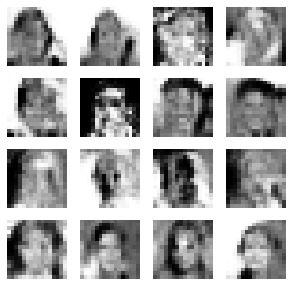

Time for epoch 17 is 36.0 sec
Epoch:  17 | Discriminator Loss:  0.64 | Accuracy:  86.88 % | Generator Loss:  1.64
---------------------------------------------------------------------------------------------------------------------------------------------------------------


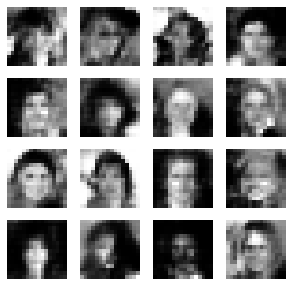

Time for epoch 18 is 36.0 sec
Epoch:  18 | Discriminator Loss:  0.76 | Accuracy:  86.88 % | Generator Loss:  1.16
---------------------------------------------------------------------------------------------------------------------------------------------------------------


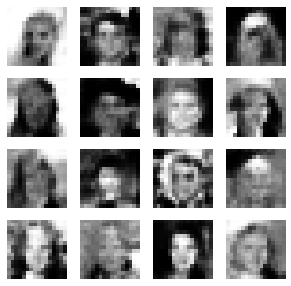

Time for epoch 19 is 36.0 sec
Epoch:  19 | Discriminator Loss:  1.5 | Accuracy:  76.67 % | Generator Loss:  1.12
---------------------------------------------------------------------------------------------------------------------------------------------------------------


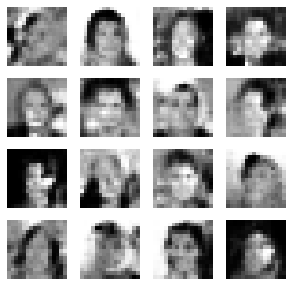

Time for epoch 20 is 36.0 sec
Epoch:  20 | Discriminator Loss:  0.92 | Accuracy:  76.67 % | Generator Loss:  1.28
---------------------------------------------------------------------------------------------------------------------------------------------------------------


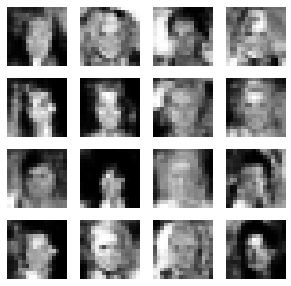

Time for epoch 21 is 36.0 sec
Epoch:  21 | Discriminator Loss:  1.32 | Accuracy:  70.83 % | Generator Loss:  0.89
---------------------------------------------------------------------------------------------------------------------------------------------------------------


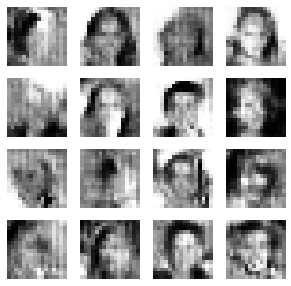

Time for epoch 22 is 36.0 sec
Epoch:  22 | Discriminator Loss:  1.08 | Accuracy:  86.88 % | Generator Loss:  0.92
---------------------------------------------------------------------------------------------------------------------------------------------------------------


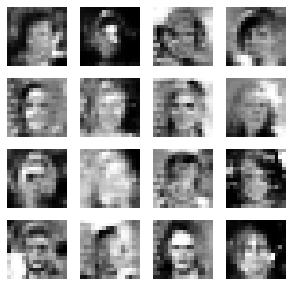

Time for epoch 23 is 36.0 sec
Epoch:  23 | Discriminator Loss:  1.31 | Accuracy:  70.0 % | Generator Loss:  1.42
---------------------------------------------------------------------------------------------------------------------------------------------------------------


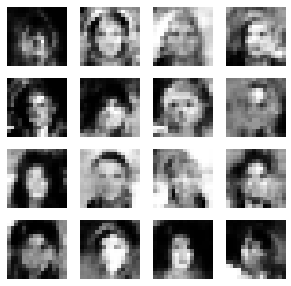

Time for epoch 24 is 36.0 sec
Epoch:  24 | Discriminator Loss:  1.26 | Accuracy:  77.08 % | Generator Loss:  0.8
---------------------------------------------------------------------------------------------------------------------------------------------------------------


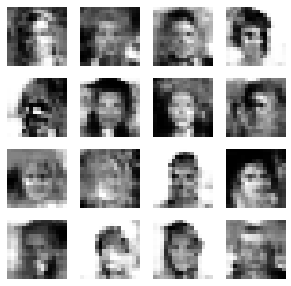

Time for epoch 25 is 36.0 sec
Epoch:  25 | Discriminator Loss:  0.98 | Accuracy:  76.88 % | Generator Loss:  0.93
---------------------------------------------------------------------------------------------------------------------------------------------------------------


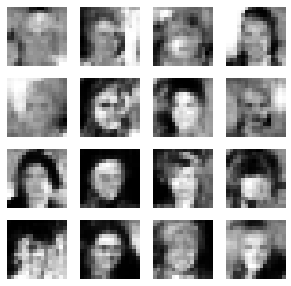

Time for epoch 26 is 36.0 sec
Epoch:  26 | Discriminator Loss:  1.14 | Accuracy:  70.42 % | Generator Loss:  0.89
---------------------------------------------------------------------------------------------------------------------------------------------------------------


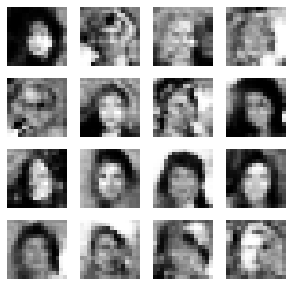

Time for epoch 27 is 36.0 sec
Epoch:  27 | Discriminator Loss:  1.23 | Accuracy:  83.54 % | Generator Loss:  1.32
---------------------------------------------------------------------------------------------------------------------------------------------------------------


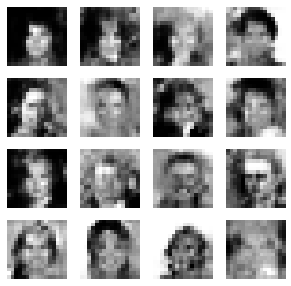

Time for epoch 28 is 36.0 sec
Epoch:  28 | Discriminator Loss:  1.09 | Accuracy:  73.33 % | Generator Loss:  1.13
---------------------------------------------------------------------------------------------------------------------------------------------------------------


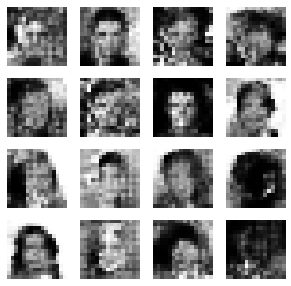

Time for epoch 29 is 36.0 sec
Epoch:  29 | Discriminator Loss:  0.97 | Accuracy:  80.21 % | Generator Loss:  0.99
---------------------------------------------------------------------------------------------------------------------------------------------------------------


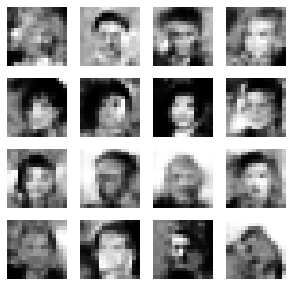

Time for epoch 30 is 36.0 sec
Epoch:  30 | Discriminator Loss:  0.82 | Accuracy:  83.33 % | Generator Loss:  1.37
---------------------------------------------------------------------------------------------------------------------------------------------------------------


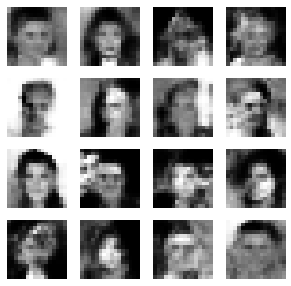

Time for epoch 31 is 36.0 sec
Epoch:  31 | Discriminator Loss:  1.19 | Accuracy:  76.67 % | Generator Loss:  1.17
---------------------------------------------------------------------------------------------------------------------------------------------------------------


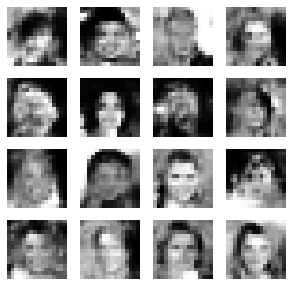

Time for epoch 32 is 36.0 sec
Epoch:  32 | Discriminator Loss:  0.71 | Accuracy:  76.88 % | Generator Loss:  1.33
---------------------------------------------------------------------------------------------------------------------------------------------------------------


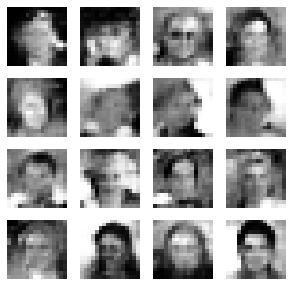

Time for epoch 33 is 36.0 sec
Epoch:  33 | Discriminator Loss:  1.0 | Accuracy:  73.75 % | Generator Loss:  1.35
---------------------------------------------------------------------------------------------------------------------------------------------------------------


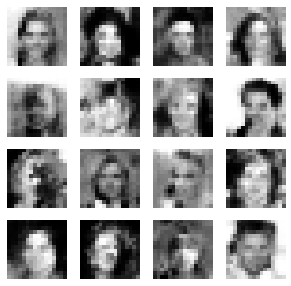

Time for epoch 34 is 36.0 sec
Epoch:  34 | Discriminator Loss:  0.84 | Accuracy:  80.83 % | Generator Loss:  1.29
---------------------------------------------------------------------------------------------------------------------------------------------------------------


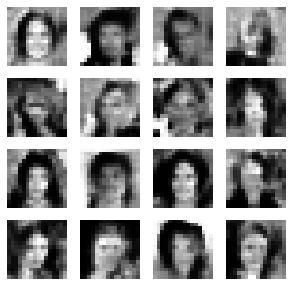

Time for epoch 35 is 36.0 sec
Epoch:  35 | Discriminator Loss:  1.28 | Accuracy:  66.67 % | Generator Loss:  1.03
---------------------------------------------------------------------------------------------------------------------------------------------------------------


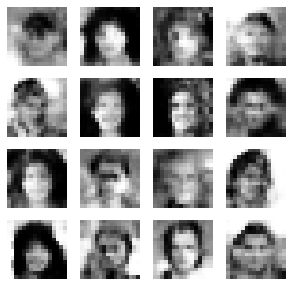

Time for epoch 36 is 36.0 sec
Epoch:  36 | Discriminator Loss:  1.32 | Accuracy:  66.67 % | Generator Loss:  1.59
---------------------------------------------------------------------------------------------------------------------------------------------------------------


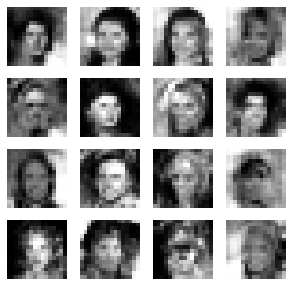

Time for epoch 37 is 36.0 sec
Epoch:  37 | Discriminator Loss:  1.11 | Accuracy:  73.54 % | Generator Loss:  0.91
---------------------------------------------------------------------------------------------------------------------------------------------------------------


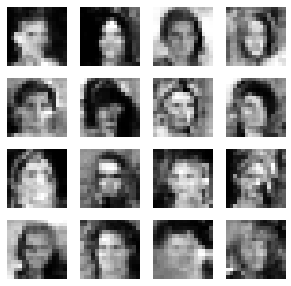

Time for epoch 38 is 36.0 sec
Epoch:  38 | Discriminator Loss:  1.26 | Accuracy:  73.33 % | Generator Loss:  1.32
---------------------------------------------------------------------------------------------------------------------------------------------------------------


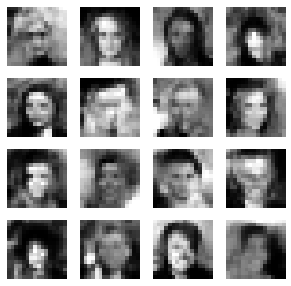

Time for epoch 39 is 36.0 sec
Epoch:  39 | Discriminator Loss:  0.97 | Accuracy:  70.0 % | Generator Loss:  1.22
---------------------------------------------------------------------------------------------------------------------------------------------------------------


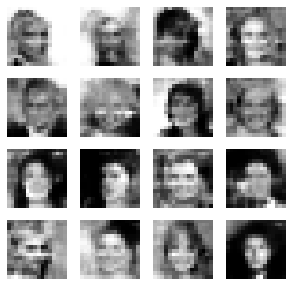

Time for epoch 40 is 36.0 sec
Epoch:  40 | Discriminator Loss:  1.36 | Accuracy:  60.21 % | Generator Loss:  0.96
---------------------------------------------------------------------------------------------------------------------------------------------------------------


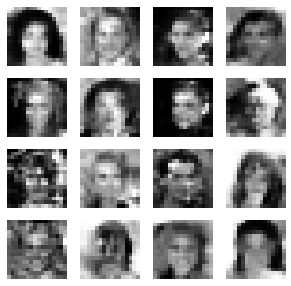

Time for epoch 41 is 36.0 sec
Epoch:  41 | Discriminator Loss:  1.47 | Accuracy:  63.54 % | Generator Loss:  0.9
---------------------------------------------------------------------------------------------------------------------------------------------------------------


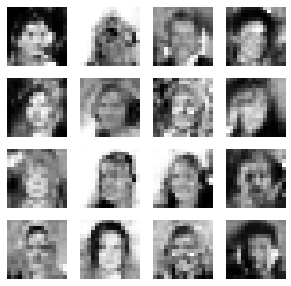

Time for epoch 42 is 36.0 sec
Epoch:  42 | Discriminator Loss:  1.24 | Accuracy:  73.33 % | Generator Loss:  0.93
---------------------------------------------------------------------------------------------------------------------------------------------------------------


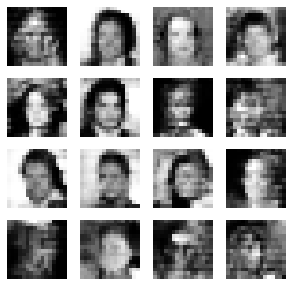

Time for epoch 43 is 36.0 sec
Epoch:  43 | Discriminator Loss:  1.97 | Accuracy:  57.71 % | Generator Loss:  0.89
---------------------------------------------------------------------------------------------------------------------------------------------------------------


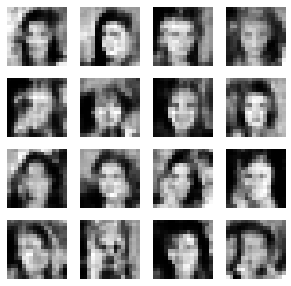

Time for epoch 44 is 36.0 sec
Epoch:  44 | Discriminator Loss:  1.38 | Accuracy:  63.54 % | Generator Loss:  0.96
---------------------------------------------------------------------------------------------------------------------------------------------------------------


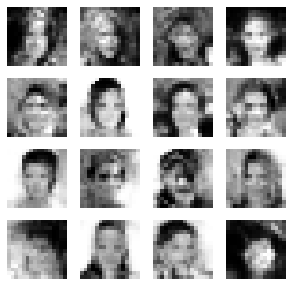

Time for epoch 45 is 36.0 sec
Epoch:  45 | Discriminator Loss:  1.41 | Accuracy:  70.42 % | Generator Loss:  1.01
---------------------------------------------------------------------------------------------------------------------------------------------------------------


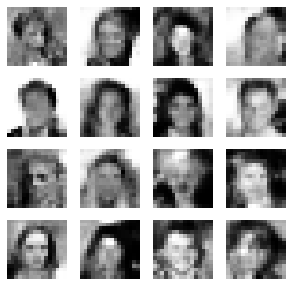

Time for epoch 46 is 36.0 sec
Epoch:  46 | Discriminator Loss:  1.31 | Accuracy:  63.75 % | Generator Loss:  0.8
---------------------------------------------------------------------------------------------------------------------------------------------------------------


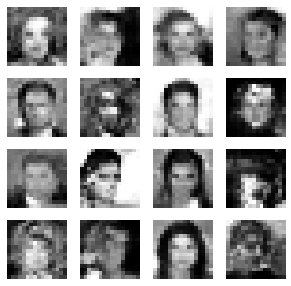

Time for epoch 47 is 36.0 sec
Epoch:  47 | Discriminator Loss:  1.37 | Accuracy:  66.67 % | Generator Loss:  0.78
---------------------------------------------------------------------------------------------------------------------------------------------------------------


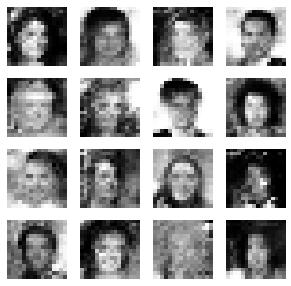

Time for epoch 48 is 36.0 sec
Epoch:  48 | Discriminator Loss:  1.25 | Accuracy:  53.96 % | Generator Loss:  0.83
---------------------------------------------------------------------------------------------------------------------------------------------------------------


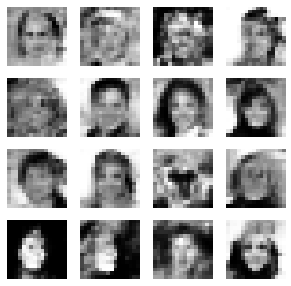

Time for epoch 49 is 36.0 sec
Epoch:  49 | Discriminator Loss:  1.1 | Accuracy:  73.33 % | Generator Loss:  0.9
---------------------------------------------------------------------------------------------------------------------------------------------------------------


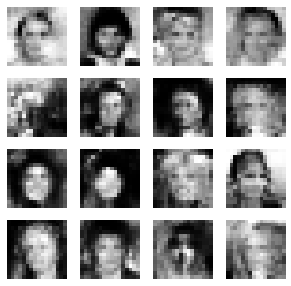

Time for epoch 50 is 36.0 sec
Epoch:  50 | Discriminator Loss:  1.2 | Accuracy:  70.0 % | Generator Loss:  0.87
---------------------------------------------------------------------------------------------------------------------------------------------------------------


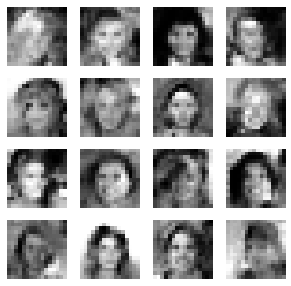

Time for epoch 51 is 36.0 sec
Epoch:  51 | Discriminator Loss:  0.99 | Accuracy:  70.0 % | Generator Loss:  1.23
---------------------------------------------------------------------------------------------------------------------------------------------------------------


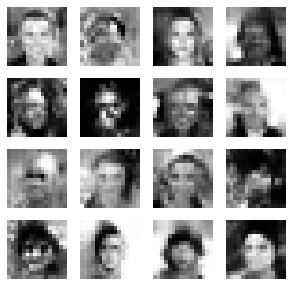

Time for epoch 52 is 36.0 sec
Epoch:  52 | Discriminator Loss:  1.5 | Accuracy:  63.33 % | Generator Loss:  1.01
---------------------------------------------------------------------------------------------------------------------------------------------------------------


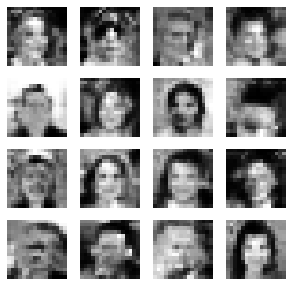

Time for epoch 53 is 36.0 sec
Epoch:  53 | Discriminator Loss:  1.46 | Accuracy:  53.33 % | Generator Loss:  1.15
---------------------------------------------------------------------------------------------------------------------------------------------------------------


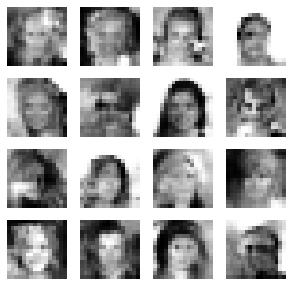

Time for epoch 54 is 36.0 sec
Epoch:  54 | Discriminator Loss:  1.72 | Accuracy:  50.62 % | Generator Loss:  0.45
---------------------------------------------------------------------------------------------------------------------------------------------------------------


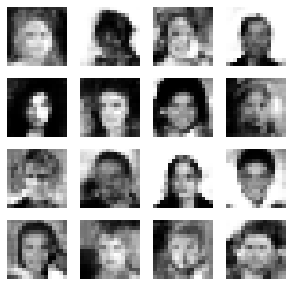

Time for epoch 55 is 36.0 sec
Epoch:  55 | Discriminator Loss:  1.44 | Accuracy:  56.88 % | Generator Loss:  0.82
---------------------------------------------------------------------------------------------------------------------------------------------------------------


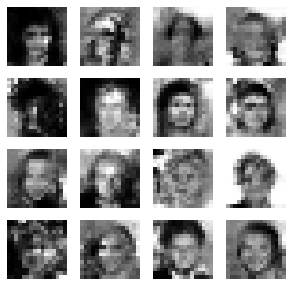

Time for epoch 56 is 36.0 sec
Epoch:  56 | Discriminator Loss:  1.28 | Accuracy:  50.0 % | Generator Loss:  1.16
---------------------------------------------------------------------------------------------------------------------------------------------------------------


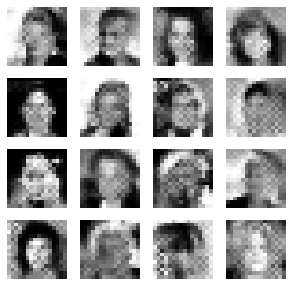

Time for epoch 57 is 36.0 sec
Epoch:  57 | Discriminator Loss:  1.19 | Accuracy:  73.33 % | Generator Loss:  0.79
---------------------------------------------------------------------------------------------------------------------------------------------------------------


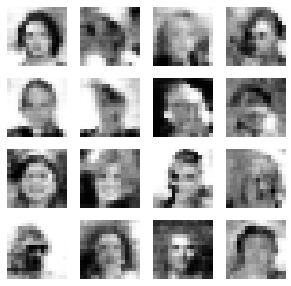

Time for epoch 58 is 36.0 sec
Epoch:  58 | Discriminator Loss:  1.25 | Accuracy:  61.04 % | Generator Loss:  0.71
---------------------------------------------------------------------------------------------------------------------------------------------------------------


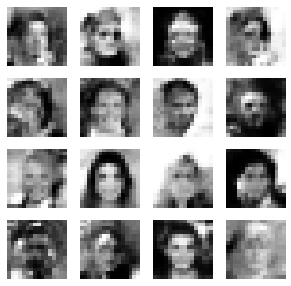

Time for epoch 59 is 36.0 sec
Epoch:  59 | Discriminator Loss:  1.14 | Accuracy:  63.33 % | Generator Loss:  1.33
---------------------------------------------------------------------------------------------------------------------------------------------------------------


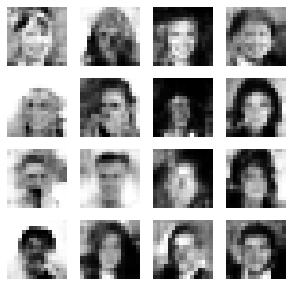

Time for epoch 60 is 36.0 sec
Epoch:  60 | Discriminator Loss:  1.0 | Accuracy:  63.33 % | Generator Loss:  1.28
---------------------------------------------------------------------------------------------------------------------------------------------------------------


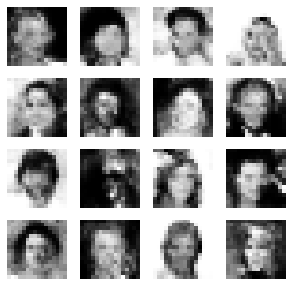

Time for epoch 61 is 36.0 sec
Epoch:  61 | Discriminator Loss:  1.44 | Accuracy:  56.88 % | Generator Loss:  0.83
---------------------------------------------------------------------------------------------------------------------------------------------------------------


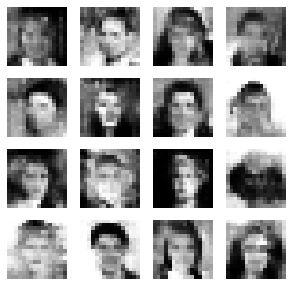

Time for epoch 62 is 36.0 sec
Epoch:  62 | Discriminator Loss:  1.52 | Accuracy:  67.29 % | Generator Loss:  0.64
---------------------------------------------------------------------------------------------------------------------------------------------------------------


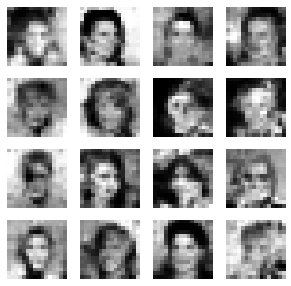

Time for epoch 63 is 36.0 sec
Epoch:  63 | Discriminator Loss:  1.33 | Accuracy:  60.62 % | Generator Loss:  0.81
---------------------------------------------------------------------------------------------------------------------------------------------------------------


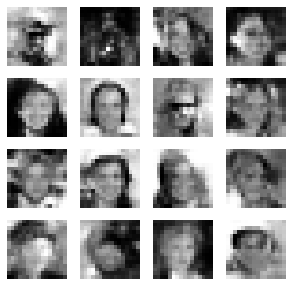

Time for epoch 64 is 36.0 sec
Epoch:  64 | Discriminator Loss:  1.38 | Accuracy:  40.83 % | Generator Loss:  0.74
---------------------------------------------------------------------------------------------------------------------------------------------------------------


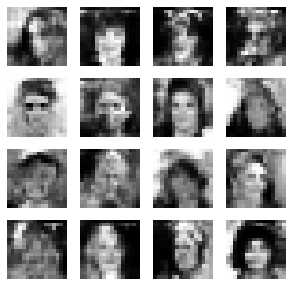

Time for epoch 65 is 36.0 sec
Epoch:  65 | Discriminator Loss:  1.38 | Accuracy:  66.67 % | Generator Loss:  0.71
---------------------------------------------------------------------------------------------------------------------------------------------------------------


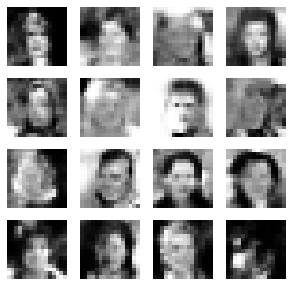

Time for epoch 66 is 36.0 sec
Epoch:  66 | Discriminator Loss:  1.34 | Accuracy:  74.58 % | Generator Loss:  0.99
---------------------------------------------------------------------------------------------------------------------------------------------------------------


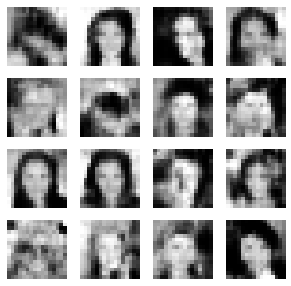

Time for epoch 67 is 36.0 sec
Epoch:  67 | Discriminator Loss:  1.33 | Accuracy:  50.42 % | Generator Loss:  0.89
---------------------------------------------------------------------------------------------------------------------------------------------------------------


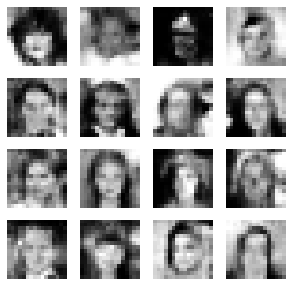

Time for epoch 68 is 36.0 sec
Epoch:  68 | Discriminator Loss:  1.24 | Accuracy:  60.42 % | Generator Loss:  0.86
---------------------------------------------------------------------------------------------------------------------------------------------------------------


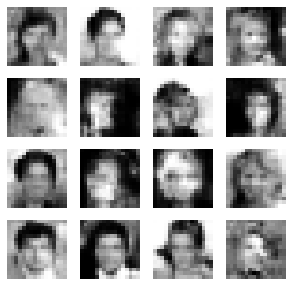

Time for epoch 69 is 36.0 sec
Epoch:  69 | Discriminator Loss:  1.54 | Accuracy:  48.12 % | Generator Loss:  0.58
---------------------------------------------------------------------------------------------------------------------------------------------------------------


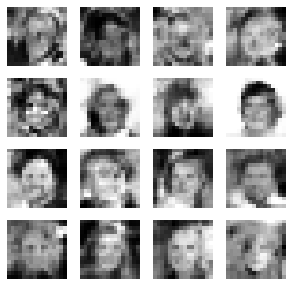

Time for epoch 70 is 36.0 sec
Epoch:  70 | Discriminator Loss:  1.28 | Accuracy:  56.88 % | Generator Loss:  0.92
---------------------------------------------------------------------------------------------------------------------------------------------------------------


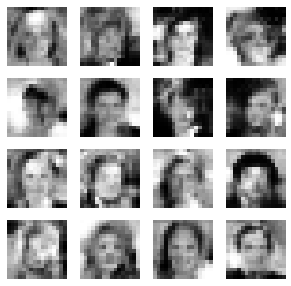

Time for epoch 71 is 36.0 sec
Epoch:  71 | Discriminator Loss:  1.42 | Accuracy:  63.54 % | Generator Loss:  0.83
---------------------------------------------------------------------------------------------------------------------------------------------------------------


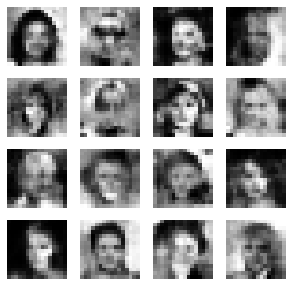

Time for epoch 72 is 36.0 sec
Epoch:  72 | Discriminator Loss:  1.36 | Accuracy:  60.42 % | Generator Loss:  0.95
---------------------------------------------------------------------------------------------------------------------------------------------------------------


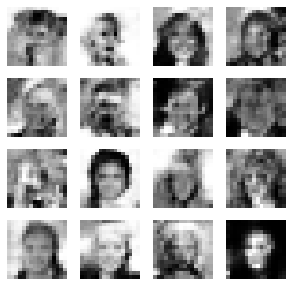

Time for epoch 73 is 36.0 sec
Epoch:  73 | Discriminator Loss:  1.44 | Accuracy:  47.71 % | Generator Loss:  0.72
---------------------------------------------------------------------------------------------------------------------------------------------------------------


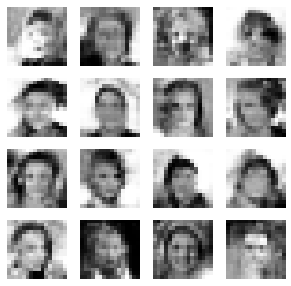

Time for epoch 74 is 36.0 sec
Epoch:  74 | Discriminator Loss:  1.28 | Accuracy:  61.25 % | Generator Loss:  0.82
---------------------------------------------------------------------------------------------------------------------------------------------------------------


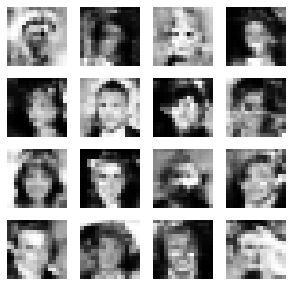

Time for epoch 75 is 36.0 sec
Epoch:  75 | Discriminator Loss:  1.53 | Accuracy:  54.79 % | Generator Loss:  0.64
---------------------------------------------------------------------------------------------------------------------------------------------------------------


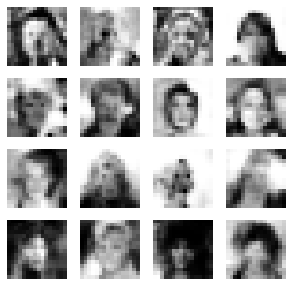

Time for epoch 76 is 36.0 sec
Epoch:  76 | Discriminator Loss:  1.37 | Accuracy:  55.83 % | Generator Loss:  0.73
---------------------------------------------------------------------------------------------------------------------------------------------------------------


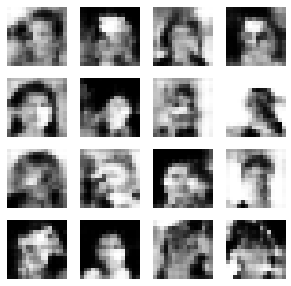

Time for epoch 77 is 36.0 sec
Epoch:  77 | Discriminator Loss:  1.56 | Accuracy:  45.42 % | Generator Loss:  0.74
---------------------------------------------------------------------------------------------------------------------------------------------------------------


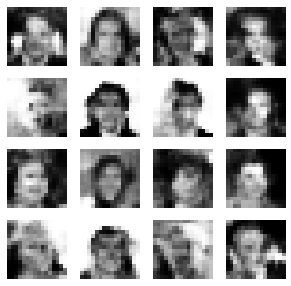

In [27]:
training_GT()

<font style="color:red"><h1>Save trained Model </h1></font>

In [33]:
generator.compile(loss="binary_crossentropy",optimizer="adam")
generator.save("16_Celeb_a_CNNgenerator")

generator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
discriminator.save("16_Celeb_a_CNNdiscriminator")

INFO:tensorflow:Assets written to: 16_Celeb_a_CNNgenerator\assets
INFO:tensorflow:Assets written to: 16_Celeb_a_CNNdiscriminator\assets


In [34]:
model = K.models.load_model("16_Celeb_a_CNNgenerator")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              1052672   
                                                                 
 batch_normalization_5 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4, 4, 512)        4719104   
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 512)       

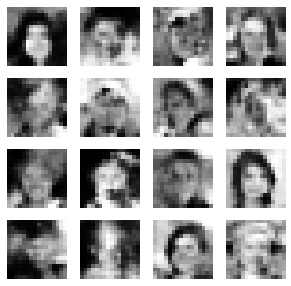

In [35]:
sampleImg(model)

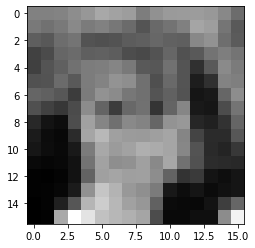

In [36]:
noise = tf.random.normal([256, zDim])
genImg = model.predict(noise)
plt.imshow(genImg[0]* 0.5 + 0.5,cmap="gray")
plt.show()

In [37]:
decision = discriminator(genImg, training = False)
print (np.mean(decision))

0.50390327
